## Health Data (Life Expectancy Prediction)

We want to create a life expectancy prediction model to find put what are the top features to contribute to average
life expectancy in the United States counties.

## Data Exploration

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
import statsmodels.api as sm

In [2]:
df1 = pd.read_csv('analytic_data2019.csv', low_memory=False)
xcl = pd.ExcelFile('2019_County_Health_Rankings_Data_v2.xls')

In [3]:
outcomes_fact_r = pd.read_excel(xcl, sheet_name='Outcomes & Factors Rankings')

In [4]:
outcomes_fact_r.columns = list(outcomes_fact_r.iloc[0])
outcomes_fact_r.drop([0],inplace=True)

In [5]:
outcomes_fact_subr = pd.read_excel(xcl, sheet_name='Outcomes & Factors SubRankings')
outcomes_fact_subr.columns = list(outcomes_fact_subr.iloc[0])
outcomes_fact_subr.drop([0],inplace=True)

In [6]:
ranked_measure = pd.read_excel(xcl, sheet_name='Ranked Measure Data')
ranked_measure.columns = list(ranked_measure.iloc[0])
ranked_measure.drop([0],inplace=True)

In [7]:
add_measure = pd.read_excel(xcl, sheet_name='Additional Measure Data')
add_measure.columns = list(add_measure.iloc[0])
add_measure.drop([0],inplace=True)

In [8]:
add_measure.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3142 entries, 1 to 3142
Columns: 111 entries, FIPS to % Rural
dtypes: object(111)
memory usage: 2.7+ MB


In [9]:
df1.drop([0],inplace=True)
df1.head()

,State FIPS Code,County FIPS Code,5-digit FIPS Code,State Abbreviation,Name,Release Year,County Ranked (Yes=1/No=0),Premature death raw value,Premature death numerator,Premature death denominator,...,Male population 18-44 raw value,Male population 45-64 raw value,Male population 65+ raw value,Total male population raw value,Female population 0-17 raw value,Female population 18-44 raw value,Female population 45-64 raw value,Female population 65+ raw value,Total female population raw value,Population growth raw value
1,00,000,00000,US,United States,2019,NaN,6900.630354,3745538,908266078,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,01,000,01000,AL,Alabama,2019,NaN,9917.2328984,80440,13636816,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,01,001,01001,AL,Autauga County,2019,1,8824.0571232,815,156132,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01,003,01003,AL,Baldwin County,2019,1,7224.6321603,2827,576496,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,01,005,01005,AL,Barbour County,2019,1,9586.165037,451,72222,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
life_exp = add_measure[['FIPS','State','County','Life Expectancy', '% Frequent Physical Distress',
                       '% Frequent Mental Distress', '% Diabetic', '% Food Insecure',
                        '% Insufficient Sleep', 'Household Income', '% Homeowners',
                       '% Severe Housing Cost Burden']]
life_exp.head()

,FIPS,State,County,Life Expectancy,% Frequent Physical Distress,% Frequent Mental Distress,% Diabetic,% Food Insecure,% Insufficient Sleep,Household Income,% Homeowners,% Severe Housing Cost Burden
1,01001,Alabama,Autauga,76.3306,12.8244,12.6384,14.2,13.4,35.9054,58343,73.2877,12.6452
2,01003,Alabama,Baldwin,78.5995,12.622,12.8226,11.3,12.3,33.3059,56607,72.8593,12.7959
3,01005,Alabama,Barbour,75.7795,16.2162,14.6323,18,23.2,38.5632,32490,62.5068,13.5868
4,01007,Alabama,Bibb,73.9283,13.163,12.854,14.9,15.8,38.1489,45795,75.3615,8.73389
5,01009,Alabama,Blount,74.5978,13.7201,13.8279,14.3,11,35.945,48253,78.521,8.1945


In [11]:
factors = ranked_measure[['FIPS',
                         '% Fair/Poor',
                         '% LBW', '% Smokers', '% Obese', 'Food Environment Index',
                         '% Physically Inactive', '% With Access', '% Excessive Drinking',
                         '% Alcohol-Impaired','Chlamydia Rate', 'Teen Birth Rate', '% Uninsured',
                          'Dentist Rate', 'MHP Rate',
                         'MHP Ratio', 'Preventable Hosp. Rate', '% Screened', '% Vaccinated',
                         'Graduation Rate', '% Some College', '% Unemployed', '% Children in Poverty',
                          'Income Ratio', '% Single-Parent Households', 'Association Rate', 'Average Daily PM2.5',
                         'Presence of violation', '% Severe Housing Problems','% Drive Alone',
                         '% Long Commute - Drives Alone']]

In [12]:
print('Factors shape:', factors.shape)
print('Life Expectancy shape:', life_exp.shape)

Factors shape: (3142, 31)
Life Expectancy shape: (3142, 12)


In [13]:
df_merged = life_exp.merge(factors, how='left',on='FIPS')

In [14]:
df_merged.dropna(subset=['Life Expectancy'], inplace=True)
df_merged.drop(['MHP Rate', 'MHP Ratio'],axis=1, inplace=True)

In [15]:
df_final = df_merged.dropna()
df_final.shape

(2738, 40)

Our aim to create a model to predict Life Expectancy by counties in the United States. 
Target value = Life Expectancy.

It is a Regression Task that we will be using independent variables from our data as predictors. We will follow feature and model selection process to reach a final model which will predict Life Expectancy most accuratly.

In [16]:
#Getting data with numerical columns 
num_col = []
for i in df_final.columns:
    if (type(df_final[i][0]) != str):
        num_col.append(i)

In [17]:
num = df_final[num_col].astype('float64')
num.head(3)

,Life Expectancy,% Frequent Physical Distress,% Frequent Mental Distress,% Diabetic,% Food Insecure,% Insufficient Sleep,Household Income,% Homeowners,% Severe Housing Cost Burden,% Fair/Poor,...,% Some College,% Unemployed,% Children in Poverty,Income Ratio,% Single-Parent Households,Association Rate,Average Daily PM2.5,% Severe Housing Problems,% Drive Alone,% Long Commute - Drives Alone
0,76.330589,12.824434,12.638357,14.2,13.4,35.905406,58343.0,73.287736,12.645206,18.411124,...,60.854665,3.863522,19.3,4.636664,24.700097,12.631731,11.7,14.954646,85.965057,38.3
1,78.599498,12.622002,12.822558,11.3,12.3,33.305868,56607.0,72.859338,12.795922,18.060458,...,66.133926,3.988336,14.7,4.518560,25.184091,10.692213,10.3,13.831725,84.719423,40.5
2,75.779457,16.216160,14.632311,18.0,23.2,38.563167,32490.0,62.506800,13.586765,25.773416,...,36.774008,5.900923,50.3,5.755063,57.215743,8.472944,11.5,15.455531,83.404353,33.8


In [18]:
#Checking for duplicates
num.duplicated().sum()

0

## Preprocessing

At this point we will create a test set and put it aside to prevent any possible generalization error
and data snooping bias in our models

For this purpose we will use sklearn train_test_split function which allow us to plit our data into multiple
datasets

In [84]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(num, test_size=0.4, random_state=42)

In [85]:
print(len(train_set))

1642


In [86]:
train_set.describe()

,Life Expectancy,% Frequent Physical Distress,% Frequent Mental Distress,% Diabetic,% Food Insecure,% Insufficient Sleep,Household Income,% Homeowners,% Severe Housing Cost Burden,% Fair/Poor,...,% Some College,% Unemployed,% Children in Poverty,Income Ratio,% Single-Parent Households,Association Rate,Average Daily PM2.5,% Severe Housing Problems,% Drive Alone,% Long Commute - Drives Alone
count,1642.000000,1642.000000,1642.000000,1642.000000,1642.000000,1642.000000,1642.000000,1642.000000,1642.000000,1642.000000,...,1642.000000,1642.000000,1642.000000,1642.000000,1642.000000,1642.000000,1642.000000,1642.000000,1642.000000,1642.000000
mean,77.285374,12.123664,12.335728,11.771133,13.791657,33.370873,51034.060292,71.471516,11.570391,17.671800,...,57.296458,4.702493,21.587637,4.527761,32.689169,13.276324,9.250914,14.192618,80.530514,31.176005
std,2.825107,2.287705,1.836382,2.602988,4.034780,4.071888,13578.881082,7.621626,3.420862,4.652676,...,11.494529,1.611186,9.082671,0.711629,9.794696,5.802586,1.812833,3.886849,5.813411,12.035394
min,66.497835,6.936987,8.128345,3.300000,3.700000,23.028348,24783.000000,26.946108,3.197807,8.289167,...,19.121601,1.759153,2.700000,2.670994,5.036556,0.000000,3.000000,5.075188,18.353071,3.200000
25%,75.391721,10.427354,10.979162,9.900000,11.100000,30.440985,42415.500000,67.604904,9.230583,14.227974,...,49.670846,3.600448,14.900000,4.024952,26.373573,9.515750,8.100000,11.586082,78.182564,21.800000
50%,77.387269,11.870226,12.246175,11.700000,13.200000,33.298960,48785.500000,72.571143,11.107397,17.018180,...,56.911549,4.449228,20.500000,4.433639,32.010942,12.525466,9.600000,13.787128,81.299093,30.700000
75%,79.149721,13.612300,13.547932,13.500000,15.800000,36.299968,56507.250000,76.684281,13.362096,20.709026,...,65.634100,5.514240,26.700000,4.879754,37.440550,15.827158,10.500000,16.205432,84.184084,39.475000
max,94.659083,20.899694,20.110109,20.900000,34.800000,46.707783,136191.000000,90.131780,28.063857,40.732355,...,88.539453,19.065964,62.300000,8.165117,79.776848,60.410793,17.800000,34.824557,92.570336,84.500000


In [87]:
#Removing outliers
train_set = train_set[(np.abs(stats.zscore(train_set)) < 3.2).all(axis=1)]
# train_set = train_set.loc[train_set['Life Expectancy'] < 82.0]
# train_set = train_set.loc[train_set['Injury Death Rate'] < 105.0]

In [88]:
print(len(train_set))

1437


In [89]:
train_set.reset_index(drop=True,inplace=True)

In [90]:
train_set.corrwith(train_set['Life Expectancy']).abs().sort_values(ascending=False).head(10)

Life Expectancy                 1.000000
% Frequent Physical Distress    0.687993
% Frequent Mental Distress      0.687955
Teen Birth Rate                 0.687579
% Fair/Poor                     0.679060
% Smokers                       0.675535
% Physically Inactive           0.670099
% Children in Poverty           0.668540
% Diabetic                      0.665632
Household Income                0.654683
dtype: float64

In [91]:
#Let's get top 7 attributes with the highest correlation to Life Expectancy to make our baseline model
# but first plot a heatmap to prevent any multicollinearity 
df_seven = train_set[['Life Expectancy', '% Smokers', '% Physically Inactive', 
               '% Frequent Physical Distress', 'Teen Birth Rate', '% Diabetic',
                     '% Frequent Mental Distress', '% Fair/Poor']]

In [92]:
df_seven.corr()

,Life Expectancy,% Smokers,% Physically Inactive,% Frequent Physical Distress,Teen Birth Rate,% Diabetic,% Frequent Mental Distress,% Fair/Poor
Life Expectancy,1.000000,-0.675535,-0.670099,-0.687993,-0.687579,-0.665632,-0.687955,-0.679060
% Smokers,-0.675535,1.000000,0.652999,0.787850,0.510924,0.659853,0.791153,0.701180
% Physically Inactive,-0.670099,0.652999,1.000000,0.592499,0.567986,0.752121,0.579258,0.626749
% Frequent Physical Distress,-0.687993,0.787850,0.592499,1.000000,0.661242,0.653162,0.946562,0.916091
Teen Birth Rate,-0.687579,0.510924,0.567986,0.661242,1.000000,0.484436,0.568396,0.758828
% Diabetic,-0.665632,0.659853,0.752121,0.653162,0.484436,1.000000,0.693399,0.628628
% Frequent Mental Distress,-0.687955,0.791153,0.579258,0.946562,0.568396,0.693399,1.000000,0.826140
% Fair/Poor,-0.679060,0.701180,0.626749,0.916091,0.758828,0.628628,0.826140,1.000000


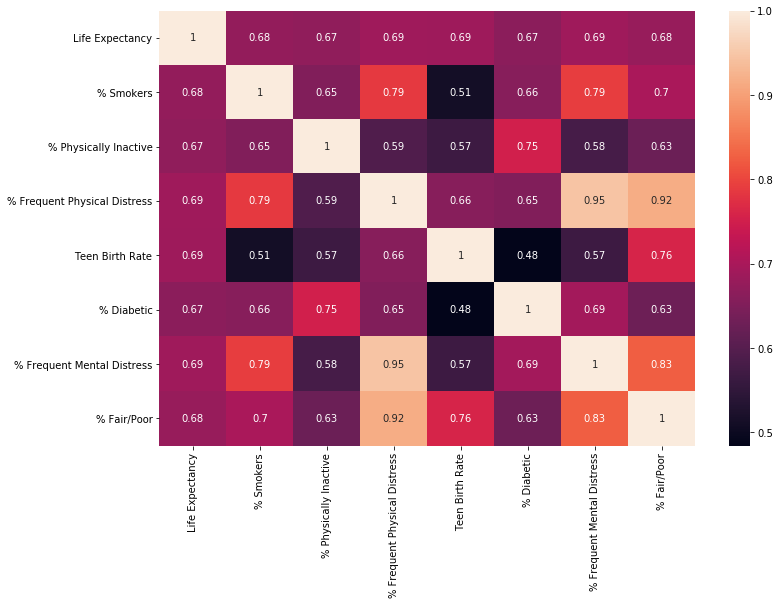

In [93]:
fig = plt.figure(figsize=(12,8))
sns.heatmap(df_seven.corr().abs(), annot=True)

There is a high chance of multicollinearity between two independent variables % Smokers, %Frequent Mental Distress and % Frequent Physical Distress and % Children in Poverty and Household Income as we see from the heatmap above they are highly related to each other.

Life Expectancy is not normal 0.0039826018784689735
% Smokers is normal
% Physically Inactive is normal
% Frequent Physical Distress is not normal 9.30753804857242e-08
Teen Birth Rate is not normal 2.061127843353791e-09
% Diabetic is not normal 0.00017596613012120507
% Frequent Mental Distress is not normal 3.585245279742865e-05
% Fair/Poor is not normal 1.3339377527926711e-11


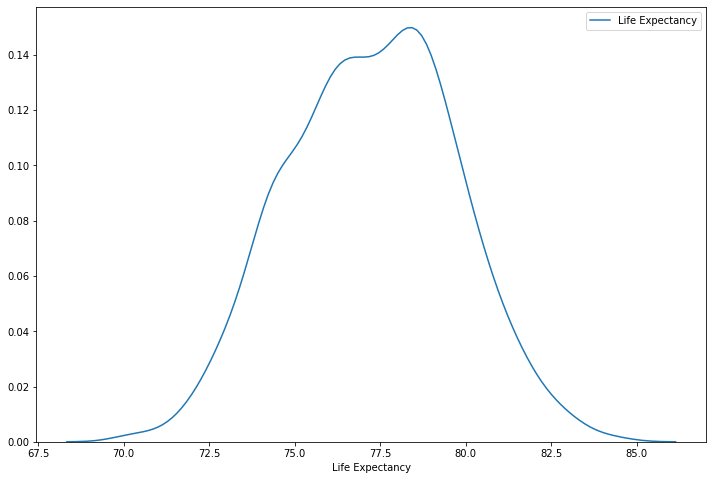

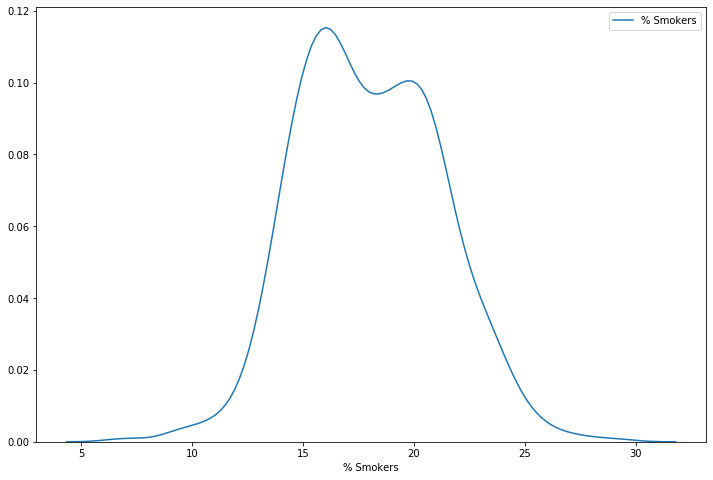

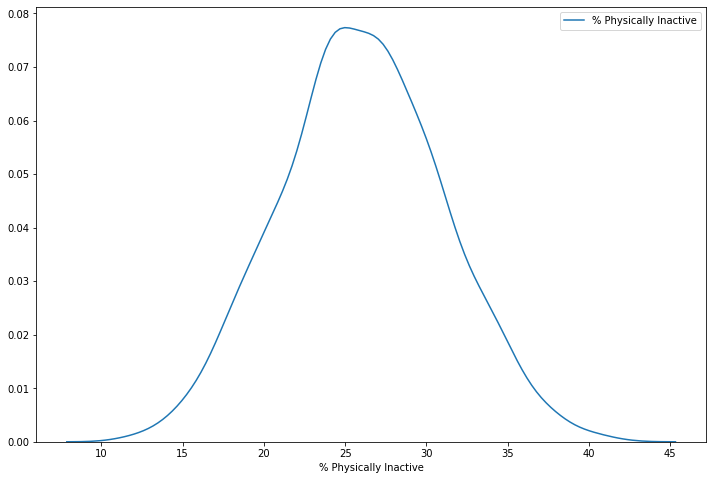

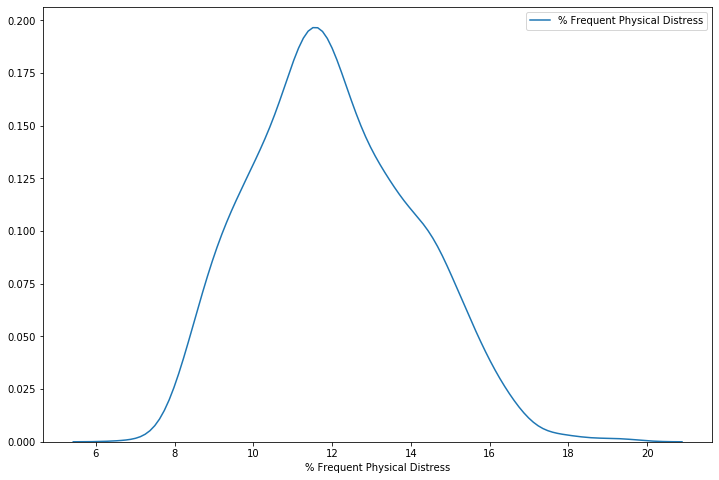

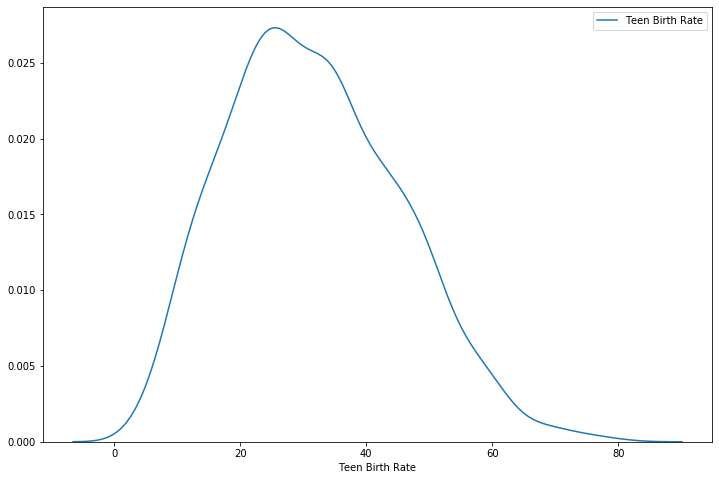

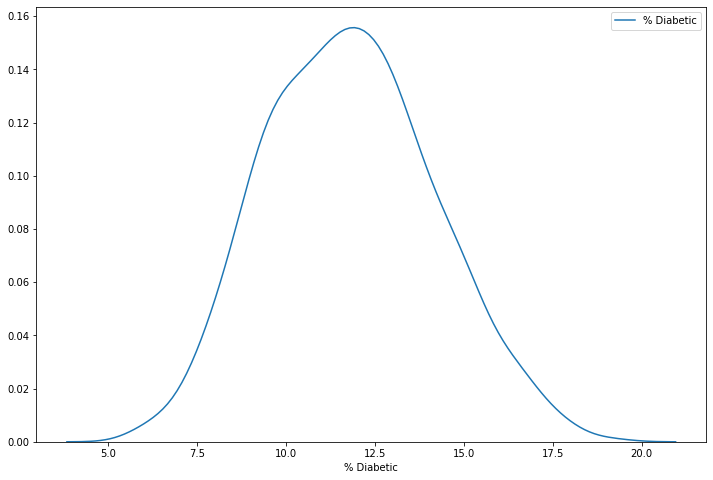

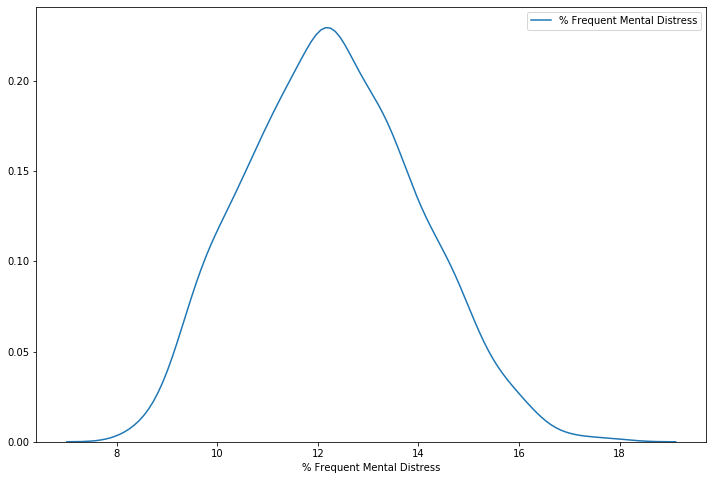

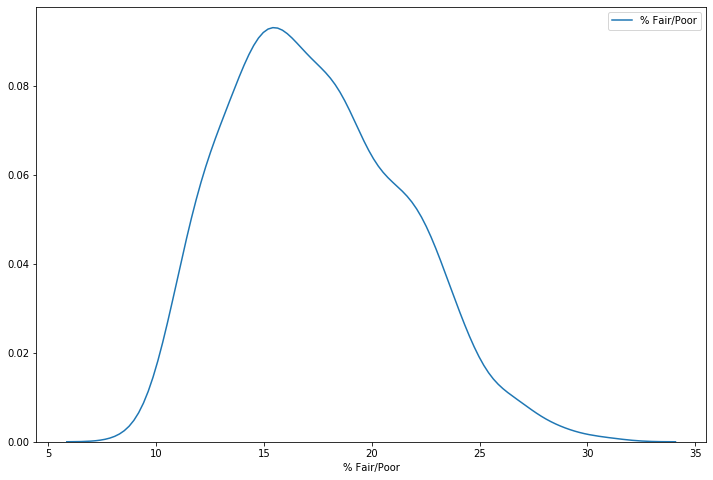

In [94]:
#Normality test
alpha = 0.05
for i in df_seven.columns:
    fig = plt.figure(figsize=(12,8))
    sns.distplot(df_seven[i], label=i, hist=False)
    k2, p = stats.normaltest(df_seven[i])
    if p < alpha:  # null hypothesis: x comes from a normal distribution
         print("%s is not normal"%i,p)
    else:
         print("%s is normal"%i)

Data doesn't look normal but for Linear Regression we don't need to normalize it since we will use Standard Scale.

In [95]:
target = train_set['Life Expectancy']
predictors1 = train_set[['% Smokers', 'Teen Birth Rate', '% Diabetic','% Physically Inactive' ]]

In [96]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled1 = scaler.fit_transform(predictors1)

In [97]:
df_scaled = pd.DataFrame(scaled1)
df_scaled.columns = predictors1.columns

We will run different regression models to see which one performs best for our task and choose a baseline model among them

## Model Selection

In [98]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [99]:
lin_reg = LinearRegression()
c_val = KFold(n_splits=5, shuffle=True, random_state=42)
# lin_reg.fit(scaled1, target)
scores = cross_val_score(lin_reg, scaled1, target, scoring='neg_mean_squared_error', cv=c_val)
lin_score_r2 = np.mean(cross_val_score(lin_reg, scaled1, target, scoring='r2', cv=c_val))
lin_scores_rmse = np.sqrt(-scores)

In [100]:
def display_scores(scores, r2):
    print('Scores: ', scores)
    print('Mean: ', scores.mean())
    print('Standard Deviation: ',scores.std())
    print('r2: ', r2)

In [101]:
display_scores(lin_scores_rmse,lin_score_r2)

Scores:  [1.47731015 1.3839299  1.42409606 1.50607368 1.31218781]
Mean:  1.4207195223579734
Standard Deviation:  0.06874858748395328
r2:  0.6601495062116124


This is our baseline model. We will try to improve the model by adding more attributes. We will use only the attributes which has more than 0.4 correlation with Life Expectancy to keep our model as simple as possible. Before that we will check training data to make sure if there is any multicollinearity between independent variable.

In [102]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=.2) #Lasso is also known as the L1 norm. 
# lasso.fit(scaled1, target)
scores_lasso = cross_val_score(lasso, scaled1, target, scoring='neg_mean_squared_error', cv=c_val)
lasso_r2 = np.mean(cross_val_score(lasso, scaled1, target, scoring='r2', cv=c_val))
lasso_rmse = np.sqrt(-scores_lasso)
display_scores(lasso_rmse, lasso_r2)

Scores:  [1.48593088 1.3952895  1.4632892  1.53689852 1.31604998]
Mean:  1.4394916153997965
Standard Deviation:  0.07668467790393299
r2:  0.6511202344655798


In [103]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()


In [104]:
tree_reg.fit(scaled1, target)
scores_tree = cross_val_score(tree_reg, scaled1, target, scoring='neg_mean_squared_error', cv=10)
tree_score_r2 = np.mean(cross_val_score(tree_reg, scaled1, target, scoring='r2', cv=c_val))
tree_rmse_scores = np.sqrt(-scores_tree)
display_scores(tree_rmse_scores, tree_score_r2)

Scores:  [1.99776906 2.0373199  1.96405389 1.93651182 2.26152012 1.91488595
 1.82383333 1.94278808 1.95264217 1.91581371]
Mean:  1.9747138030284
Standard Deviation:  0.10936264086164188
r2:  0.31231340262399654


In [105]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()


In [106]:
forest_reg.fit(scaled1, target)
scores_forest = cross_val_score(forest_reg, scaled1, target, scoring='neg_mean_squared_error', cv=10)
forest_score_r2 = np.mean(cross_val_score(forest_reg, scaled1, target, scoring='r2', cv=c_val))
forest_rmse_scores = np.sqrt(-scores_forest)
display_scores(forest_rmse_scores, forest_score_r2)

//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Scores:  [1.56385201 1.59787441 1.46838929 1.61931912 1.60241429 1.49642254
 1.54252163 1.46821383 1.47057795 1.43713241]
Mean:  1.5266717479621932
Standard Deviation:  0.06317980101897405
r2:  0.6005979357365727


Our baseline model will be the Linear Regression model.  We will try to improve the model by adding more attributes. We will use only the attributes which has more than 0.4 correlation with Life Expectancy to keep our model as simple as possible. Before that we will check training data to make sure if there is any multicollinearity between independent variable.

## Preprocessing before improving the model

In [107]:
attributes = pd.DataFrame(train_set.corrwith(train_set['Life Expectancy']).abs() > 0.3)
attributes.reset_index(inplace=True)
attributes.columns = ['Attribute','Correlation']
list_attr = attributes.loc[attributes['Correlation'] == True, 'Attribute']

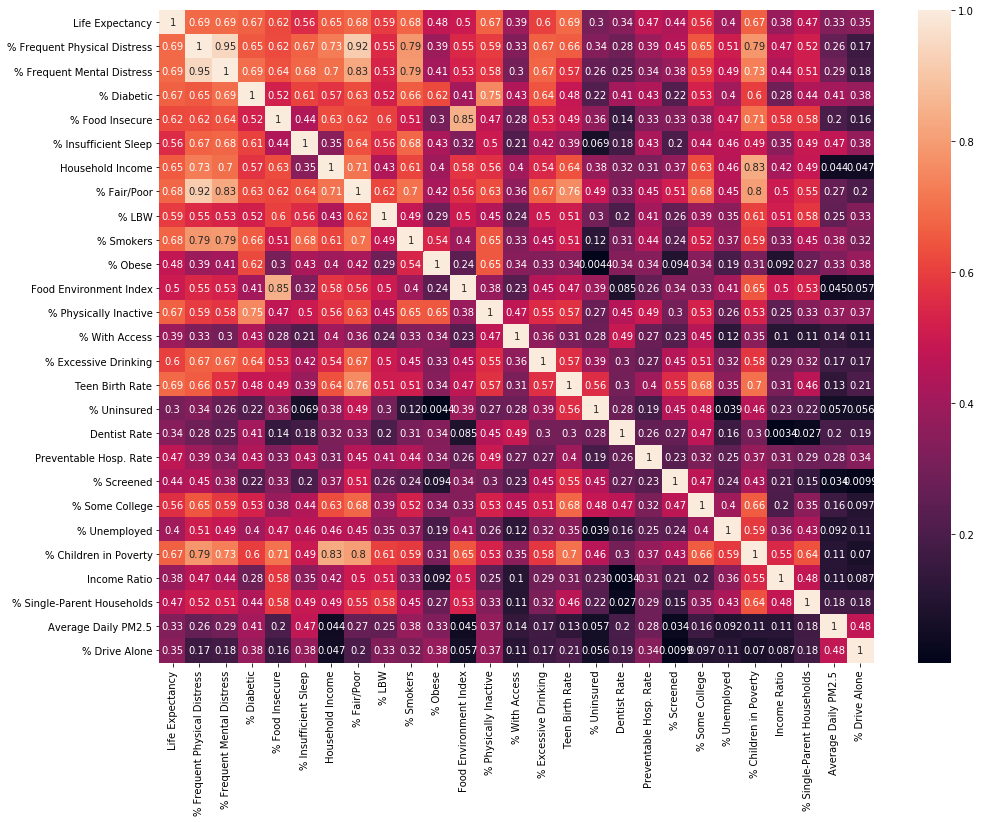

In [108]:
df_att = train_set[list(list_attr)]
fig = plt.figure(figsize=(16,12))
sns.heatmap(df_att.corr().abs(), annot=True)

Preventing multicoliinearity in our model

In [109]:
corr = df_att.corr() < 0.75
corr.reset_index(drop=False,inplace=True)
corr.rename(columns={'index': 'Attribute'},inplace=True)

In [110]:
for i in corr.columns:
    for j in list(range(1,len(corr))):
        if corr[i][j] == False:
            if i != corr.Attribute[j]:
                print(f'High chance of multicollinearity between: {i} and {corr.Attribute[j]}\n')
            else:
                pass
        else:
            pass

High chance of multicollinearity between: % Frequent Physical Distress and % Frequent Mental Distress

High chance of multicollinearity between: % Frequent Physical Distress and % Fair/Poor

High chance of multicollinearity between: % Frequent Physical Distress and % Smokers

High chance of multicollinearity between: % Frequent Physical Distress and % Children in Poverty

High chance of multicollinearity between: % Frequent Mental Distress and % Frequent Physical Distress

High chance of multicollinearity between: % Frequent Mental Distress and % Fair/Poor

High chance of multicollinearity between: % Frequent Mental Distress and % Smokers

High chance of multicollinearity between: % Diabetic and % Physically Inactive

High chance of multicollinearity between: % Fair/Poor and % Frequent Physical Distress

High chance of multicollinearity between: % Fair/Poor and % Frequent Mental Distress

High chance of multicollinearity between: % Fair/Poor and Teen Birth Rate

High chance of multicol

The variables we should exclude from our model are:
% Frequent Physical Distress 
% Frequent Mental Distress

In [111]:
multicollinear = ['% Frequent Physical Distress', '% Frequent Mental Distress', '% Children in Poverty', '% Physically Inactive']

In [112]:
predict_variables = df_att.drop(multicollinear, axis=1)
predict_variables.drop('Life Expectancy', axis=1, inplace=True)

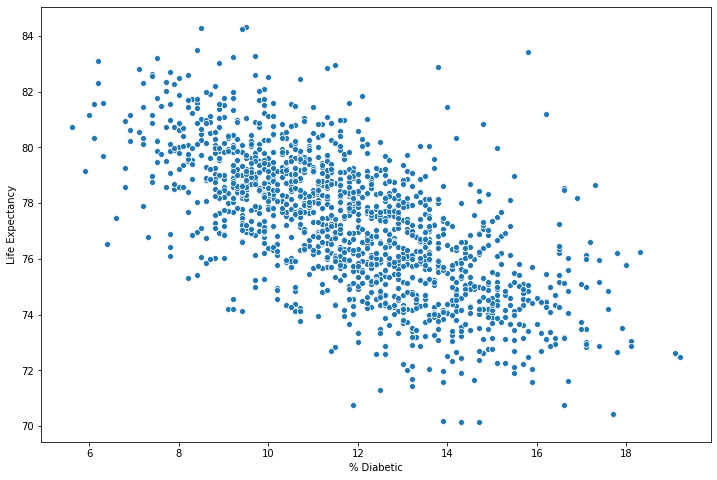

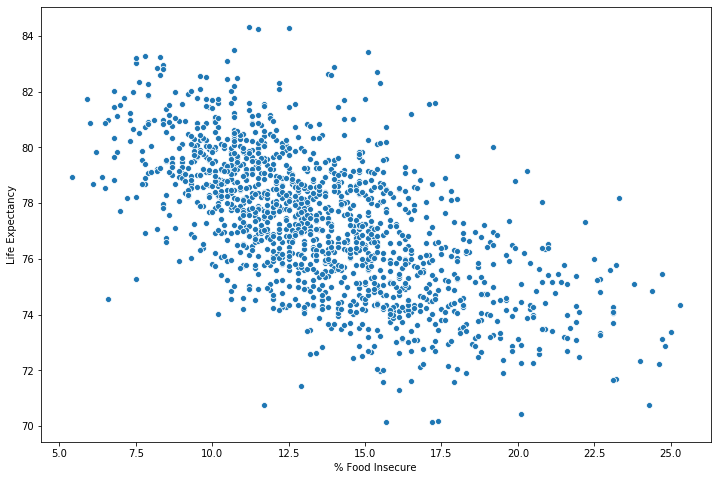

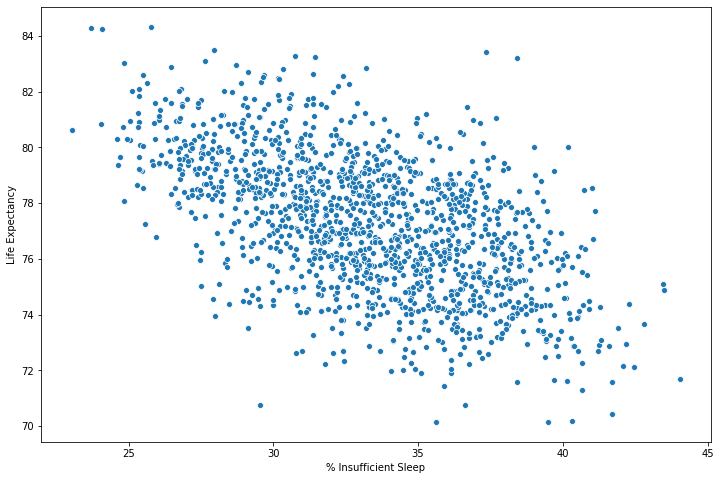

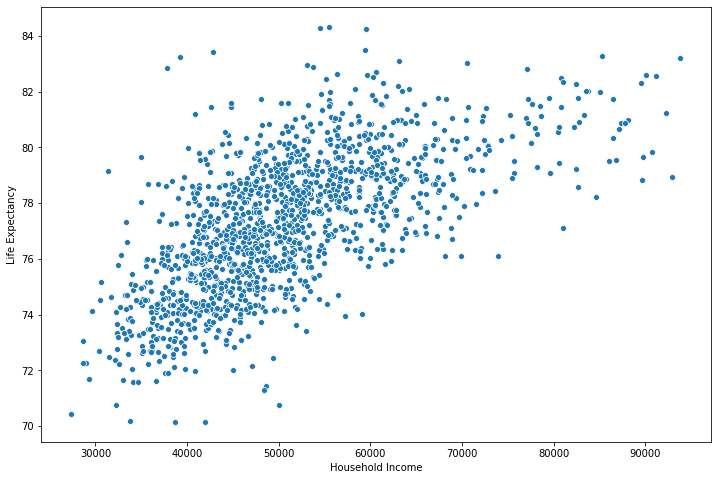

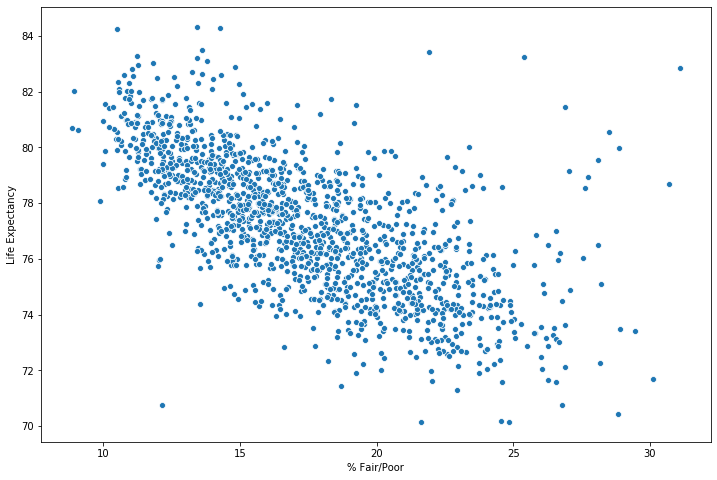

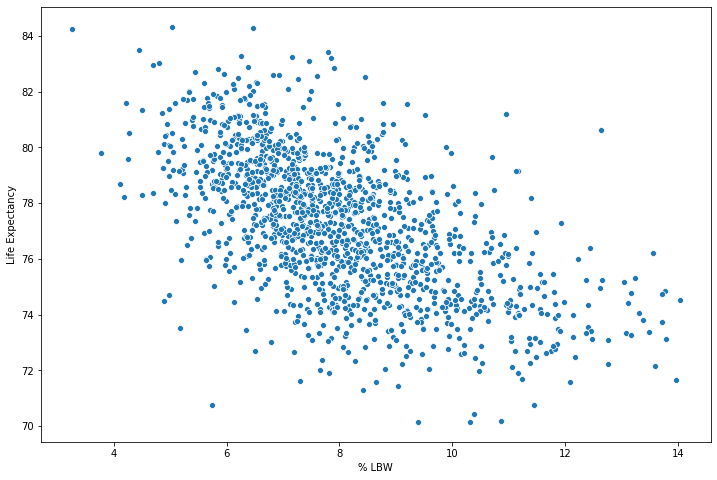

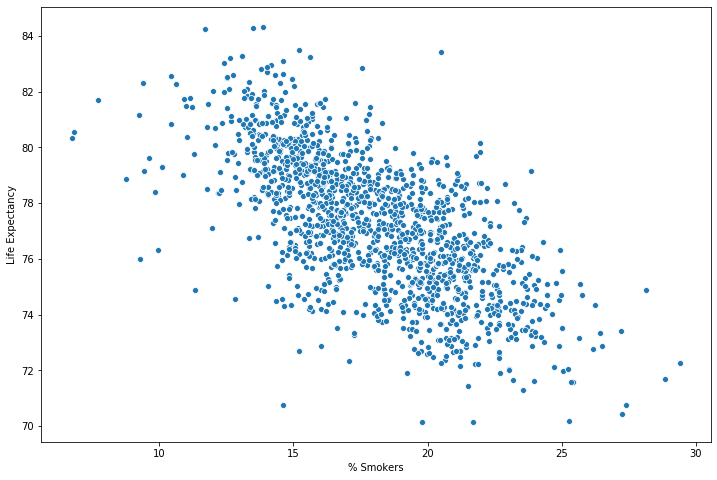

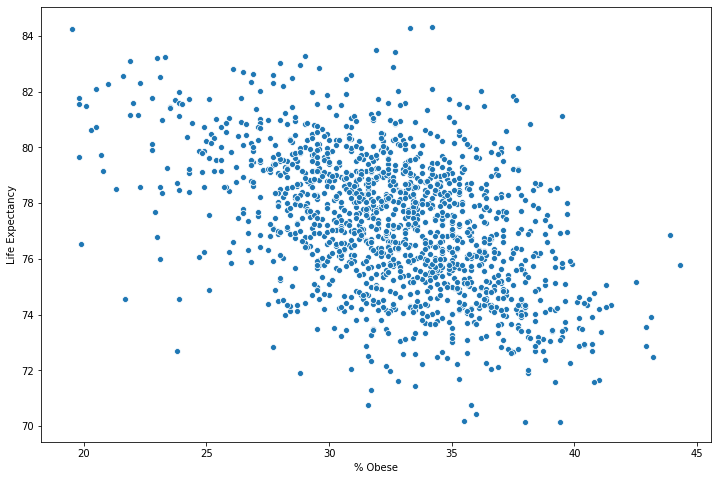

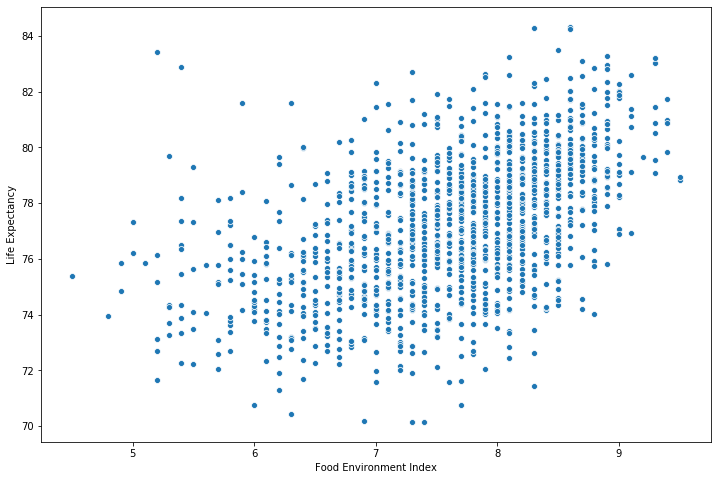

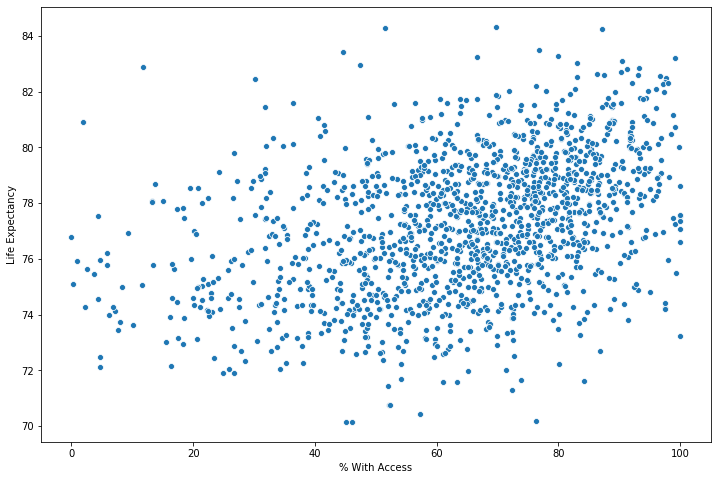

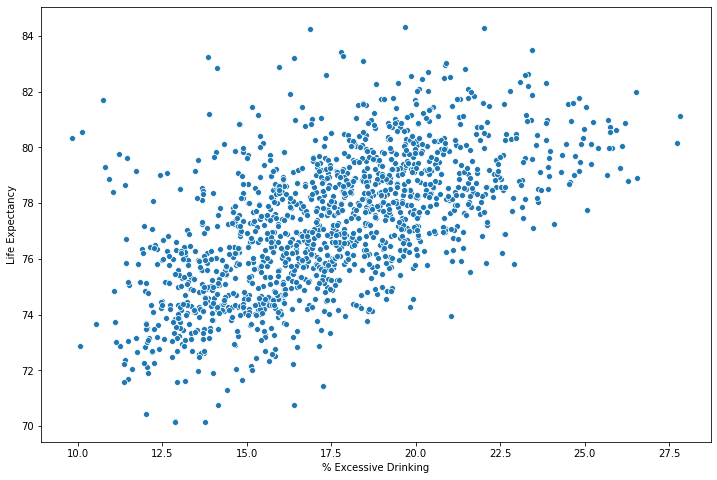

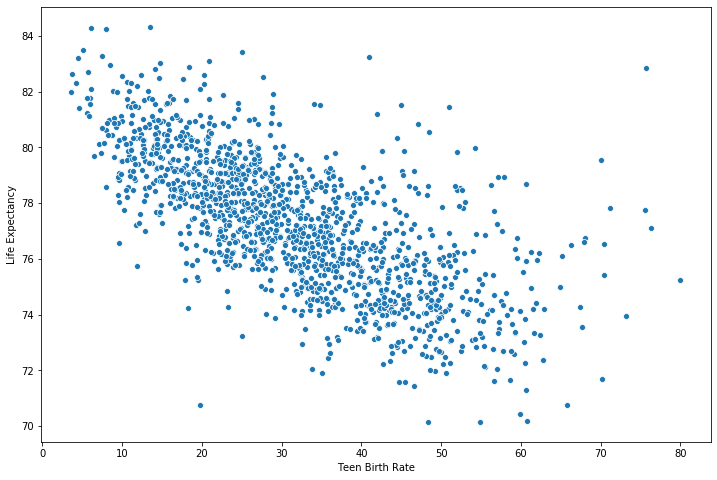

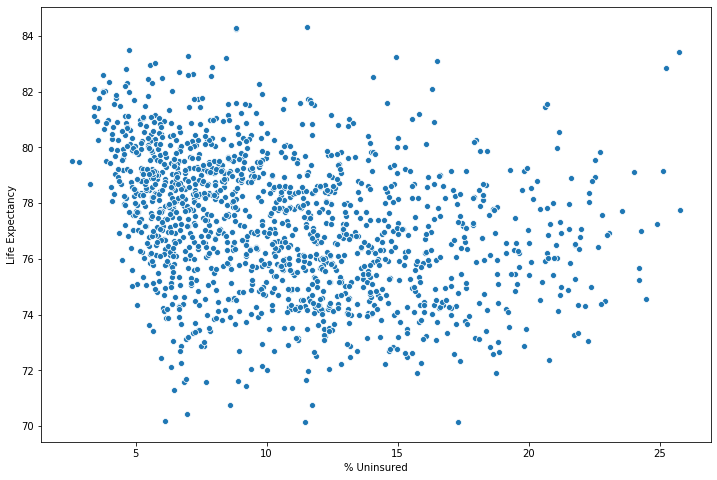

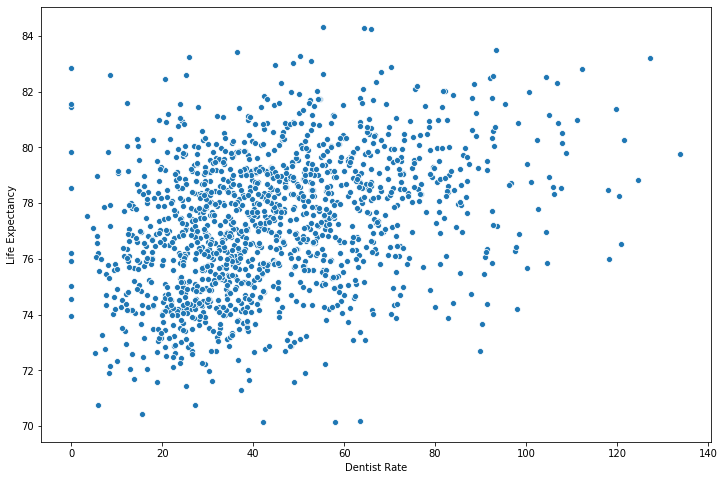

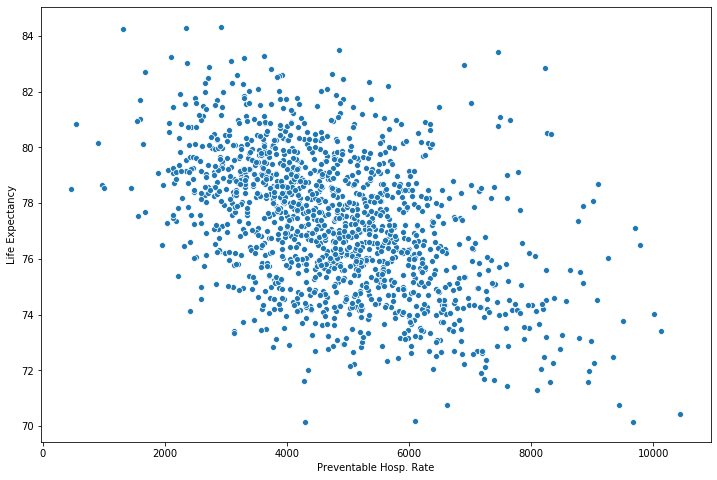

In [ ]:
for i in predict_variables.columns:
    fig = plt.figure(figsize=(12,8))
    sns.scatterplot(x = predict_variables[i],y=target)
    plt.xlabel(i)
    plt.ylabel('Life Expectancy')
    plt.show()

In [ ]:
predict_variables.drop(['% Screened', 'Food Environment Index','Average Daily PM2.5'],axis=1, inplace=True)

## Running a new model

In [ ]:
#Scaling the training set
scaler = StandardScaler()
scaled = scaler.fit_transform(predict_variables)

In [ ]:
df1_scaled = pd.DataFrame(scaled , columns=predict_variables.columns)

In [ ]:
lin_reg = LinearRegression()
c_val = KFold(n_splits=5, shuffle=True, random_state=42)
scores0 = cross_val_score(lin_reg, scaled, target, scoring='neg_mean_squared_error', cv=c_val)
lin_score0_r2 = np.mean(cross_val_score(lin_reg, scaled, target, scoring='r2', cv=c_val))
lin_scores0_rmse = np.sqrt(-scores0)

In [ ]:
display_scores(lin_scores0_rmse,lin_score0_r2)

In [ ]:
import statsmodels.api as sm
preds = sm.add_constant(df1_scaled)
ols_model = sm.OLS(target,preds)
ols_result = ols_model.fit()

In [ ]:
k2_resid, p_resid = stats.normaltest(ols_result.resid)
if p_resid < alpha:  # null hypothesis: x comes from a normal distribution
    print("Residual is not normal",p_resid)
else:
    print("Residual is normal")
sns.distplot(ols_result.resid)

Our residuals are little bit skewed but close to normal.

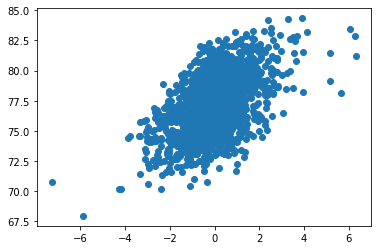

In [81]:
plt.scatter(ols_result.resid,target)

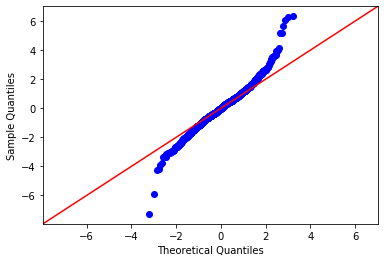

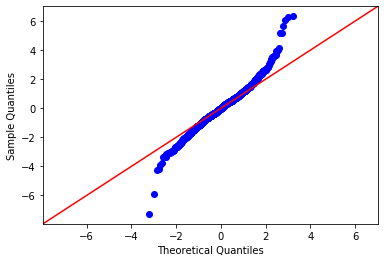

In [82]:
sm.qqplot(ols_result.resid, line='45')

In [83]:
ols_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Life Expectancy   R-squared:                       0.725
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     203.6
Date:                Tue, 14 Jan 2020   Prob (F-statistic):               0.00
Time:                        18:23:08   Log-Likelihood:                -2505.7
No. Observations:                1487   AIC:                             5051.
Df Residuals:                    1467   BIC:                             5158.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         77.2901      0.034   2268.591      0.000      77.223      77.357
% Diabetic                    -0.1909      0.065     -2.942      0.003      -0.318      -0.064
% Food Insecure               -0.4223      0.059     -7.196      0.000      -0.537      -0.307
% Insufficient Sleep          -0.2524      0.062     -4.081      0.000      -0.374      -0.131
Household Income               0.3766      0.063      5.992      0.000       0.253       0.500
% Fair/Poor                    0.5695      0.085      6.672      0.000       0.402       0.737
% LBW                         -0.2256      0.053     -4.233      0.000      -0.330      -0.121
% Smokers                     -0.4875      0.064     -7.586      0.000      -0.614      -0.361
% Obese                       -0.0654      0.049     -1.330      0.184      -0.162       0.031
% With Access                  0.0769      0.043      1.775      0.076      -0.008       0.162
% Excessive Drinking           0.2958      0.055      5.409      0.000       0.189       0.403
Teen Birth Rate               -0.9160      0.064    -14.357      0.000      -1.041      -0.791
% Uninsured                    0.1182      0.051      2.310      0.021       0.018       0.219
Dentist Rate                   0.0859      0.045      1.920      0.055      -0.002       0.174
Preventable Hosp. Rate        -0.1489      0.042     -3.519      0.000      -0.232      -0.066
% Some College                -0.0123      0.060     -0.206      0.837      -0.129       0.105
% Unemployed                   0.0519      0.046      1.132      0.258      -0.038       0.142
Income Ratio                  -0.0516      0.048     -1.087      0.277      -0.145       0.042
% Single-Parent Households     0.0849      0.050      1.702      0.089      -0.013       0.183
% Drive Alone                 -0.1606      0.042     -3.831      0.000      -0.243      -0.078
==============================================================================
Omnibus:                       90.292   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              336.066
Skew:                           0.154   Prob(JB):                     1.06e-73
Kurtosis:                       5.308   Cond. No.                         8.35
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Adding polynomial features

In [59]:
from sklearn.preprocessing import PolynomialFeatures

In [60]:
poly = PolynomialFeatures(2)
df1_poly = poly.fit_transform(df1_scaled)

In [61]:
scores_poly = cross_val_score(lin_reg, df1_poly, target, scoring='neg_mean_squared_error', cv=c_val)
poly_score_r2 = np.mean(cross_val_score(lin_reg, df1_poly, target, scoring='r2', cv=c_val))
poly_rmse = np.sqrt(-scores_poly)

In [62]:
display_scores(poly_rmse,poly_score_r2)

Scores:  [1.31089554 1.35173591 1.44900791 1.4226002  1.50953616]
Mean:  1.4087551430392309
Standard Deviation:  0.07042227035892966
r2:  0.6770676233189287


In [63]:
preds_poly = sm.add_constant(df1_poly)
poly_ols_model = sm.OLS(target,preds_poly)
poly_ols_result = poly_ols_model.fit()

Residual is not normal 6.079027106891856e-18


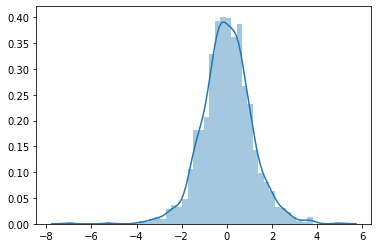

In [64]:
k2_resid, p_resid_poly = stats.normaltest(poly_ols_result.resid)
if p_resid_poly < alpha:  # null hypothesis: x comes from a normal distribution
    print("Residual is not normal",p_resid_poly)
else:
    print("Residual is normal")
sns.distplot(poly_ols_result.resid)

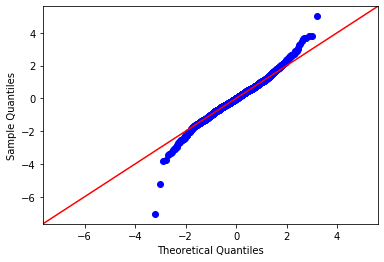

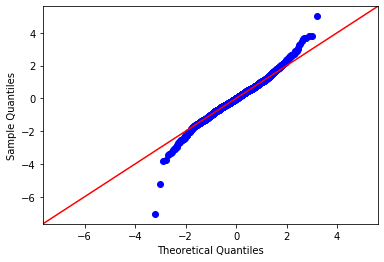

In [65]:
sm.qqplot(poly_ols_result.resid, line='45')

In [66]:
poly_ols_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Life Expectancy   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     22.25
Date:                Tue, 14 Jan 2020   Prob (F-statistic):          1.02e-317
Time:                        18:20:48   Log-Likelihood:                -2258.2
No. Observations:                1487   AIC:                             4978.
Df Residuals:                    1256   BIC:                             6204.
Df Model:                         230                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         77.0546      0.114    677.781      0.000      76.832      77.278
x1            -0.0180      0.078     -0.231      0.817      -0.171       0.135
x2            -0.3794      0.087     -4.370      0.000      -0.550      -0.209
x3            -0.2182      0.074     -2.967      0.003      -0.363      -0.074
x4             0.5472      0.098      5.582      0.000       0.355       0.740
x5             0.3417      0.118      2.887      0.004       0.109       0.574
x6            -0.2925      0.067     -4.381      0.000      -0.424      -0.162
x7            -0.3275      0.086     -3.797      0.000      -0.497      -0.158
x8            -0.1536      0.056     -2.729      0.006      -0.264      -0.043
x9             0.0926      0.056      1.656      0.098      -0.017       0.202
x10            0.2227      0.074      3.005      0.003       0.077       0.368
x11           -0.8246      0.081    -10.170      0.000      -0.984      -0.666
x12            0.1337      0.074      1.797      0.073      -0.012       0.280
x13            0.1093      0.052      2.092      0.037       0.007       0.212
x14           -0.1265      0.050     -2.536      0.011      -0.224      -0.029
x15            0.0240      0.071      0.336      0.737      -0.116       0.164
x16            0.0283      0.062      0.459      0.647      -0.093       0.149
x17           -0.1024      0.056     -1.815      0.070      -0.213       0.008
x18           -0.0019      0.064     -0.030      0.976      -0.127       0.123
x19           -0.1309      0.061     -2.130      0.033      -0.251      -0.010
x20           -0.1118      0.055     -2.048      0.041      -0.219      -0.005
x21            0.0235      0.086      0.272      0.786      -0.146       0.193
x22            0.0235      0.125      0.188      0.851      -0.222       0.269
x23           -0.2116      0.126     -1.675      0.094      -0.459       0.036
x24            0.1612      0.152      1.057      0.291      -0.138       0.460
x25            0.2131      0.175      1.218      0.223      -0.130       0.556
x26            0.0495      0.108      0.457      0.647      -0.163       0.262
x27           -0.1702      0.129     -1.315      0.189      -0.424       0.084
x28            0.0641      0.107      0.598      0.550      -0.146       0.274
x29           -0.0512      0.087     -0.586      0.558      -0.223       0.120
x30            0.1393      0.118      1.180      0.238      -0.092       0.371
x31            0.0381      0.123      0.310      0.757      -0.203       0.279
x32            0.0869      0.100      0.868      0.386      -0.110       0.283
x33            0.0678      0.090      0.751      0.453      -0.109       0.245
x34            0.0371      0.081      0.456      0.648      -0.122       0.196
x35           -0.0714      0.116     -0.616      0.538      -0.299       0.156
x3

Adding polynomial features also didn't improve our model as well.